In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from astropy.io import fits
pandarallel.initialize(progress_bar=True)
import random
from numpy.random import default_rng
import numpy as np
rng = default_rng(42)
import shutil
import glob
from scipy import ndimage

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
path_data = "/home/nicolas/nico/Data/SAD_CNN"

In [3]:
df = pd.read_csv("labels/zvar/Detecciones_zvar - Hoja 2.csv")

In [5]:
df_final = pd.DataFrame({})
for i in range(24,34):
    i = str(i)
    df_variable = df[["AU"]] +"_SB"+i
    df_variable["label"] = df[i]
    df_final = pd.concat([df_final,df_variable])

In [6]:
df_final = df_final.reset_index(drop=True)
df_final["brillo"] = df_final["AU"].str.split("_SB").str[-1]
df_final["brillo"] = df_final["brillo"].astype(float)

In [7]:
df_final.loc[df_final.sample(frac=0.1,weights='brillo',random_state=2).index,"subgrup"] = "test"
mask1 = df_final.loc[df_final["subgrup"]!="test"].sample(frac=0.21,weights='brillo',random_state=42).index
df_final.loc[mask1,"subgrup"] = "val"
df_final.loc[df_final["subgrup"].isna(),"subgrup"] = "train"


/tmp/ipykernel_27122/2041415555.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


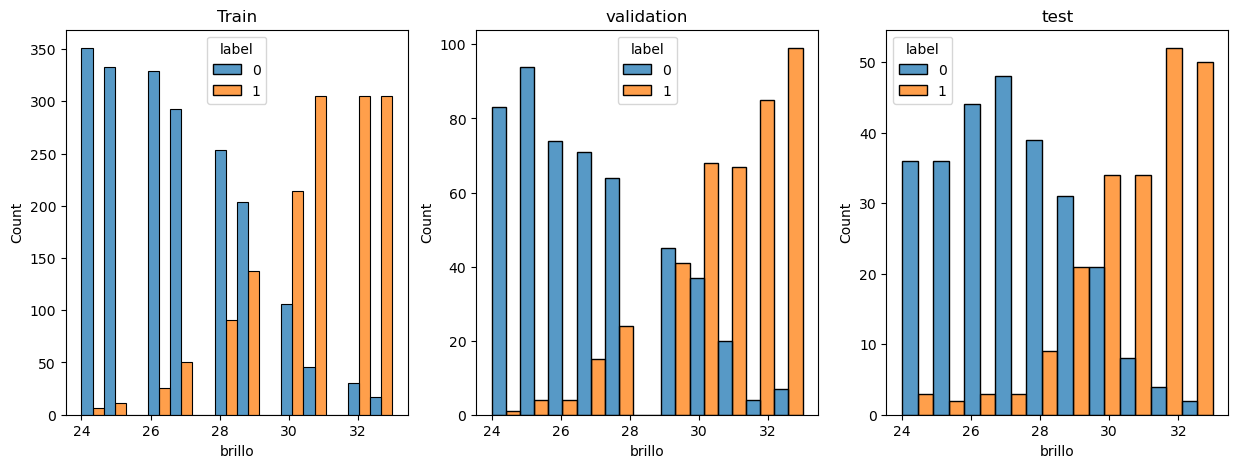

In [8]:
fig,ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(ax=ax[0],data=df_final.loc[df_final["subgrup"]=="train"],x="brillo",hue="label", multiple="dodge")
sns.histplot(ax=ax[1],data=df_final.loc[df_final["subgrup"]=="val"],x="brillo",hue="label", multiple="dodge")
sns.histplot(ax=ax[2],data=df_final.loc[df_final["subgrup"]=="test"],x="brillo",hue="label", multiple="dodge")
ax[0].set_title('Train')
ax[1].set_title('validation')
ax[2].set_title('test')
fig.show()

In [9]:
def abrir_fits(ruta):
    hdu_list = fits.open(ruta,memmap=False)
    image_data = hdu_list[0].data
    hdu_list.close()
    return image_data

In [10]:
def data_augmentation(path_plots,nomb,img,rng,tipo,numero):
    '''
    Función que genera una imagen fits con rotación al azar entre 0 y 360
    El rng permite que no se repitan las rotaciones
    hay un choice para seleccionar flip en el eje x, y o ambos
    '''

    angulo_de_rotacion = rng.choice(360, size=1, replace=False)[0]
    img_rotate = ndimage.rotate(img,angulo_de_rotacion, reshape=False,mode='reflect')
    flip_x = np.fliplr(img_rotate)
    flip_y = np.flipud(img_rotate)
    flip_xy = np.flipud(np.fliplr(img_rotate))
    mylist = [flip_x,flip_y,flip_xy]
    random_image = random.choice(mylist)
    plt.imshow(random_image, cmap=plt.cm.brg)
    hdu = fits.PrimaryHDU(random_image)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(f'{path_plots}{tipo}/{numero}_{nomb}.fits',overwrite=True)
    return

In [11]:
train = df_final.loc[df_final["subgrup"]=="train"].reset_index(drop=True)
val = df_final.loc[df_final["subgrup"]=="val"].reset_index(drop=True)
test = df_final.loc[df_final["subgrup"]=="test"].reset_index(drop=True)

In [12]:
train.to_csv("labels/zvar/train.csv",index=False)
val.to_csv("labels/zvar/val.csv",index=False)
test.to_csv("labels/zvar/test.csv",index=False)

In [13]:
train["image"] = train.parallel_apply(lambda row : abrir_fits(f"{path_data}/fits_zvar/"+ row["AU"]+".fits"), axis=1)


In [14]:
numero_training = train.groupby(["brillo","label"]).count()["AU"].max()

In [16]:
%mkdir $path_data/fits_zvar/data_augmentation/

In [17]:
%mkdir $path_data/fits_zvar/data_augmentation/0

In [18]:
%mkdir $path_data/fits_zvar/data_augmentation/1

In [19]:
training_df = train.loc[train["label"]==1].reset_index(drop=True)
grouped = training_df.groupby(training_df["brillo"])
for tipos in training_df["brillo"].unique() :
    
    training = grouped.get_group(tipos)
    if numero_training == len(training):
        continue
    if numero_training/len(training) < 2:
            training.head(numero_training - len(training)).parallel_apply(lambda row : data_augmentation(f"{path_data}/fits_zvar/data_augmentation/",row["AU"],row["image"],rng,row["label"],"f"),axis=1,result_type="expand")
    else : 
        numero_entero = int(numero_training/len(training))
        if numero_training-len(training)*numero_entero != 0 :
            training.head(numero_training-len(training)*numero_entero).parallel_apply(lambda row : data_augmentation(f"{path_data}/fits_zvar/data_augmentation/",row["AU"],row["image"],rng,row["label"],"f"),axis=1,result_type="expand")
        rng = default_rng(42)
        for i in range(numero_entero-1):
            training.head(numero_training - len(training)).parallel_apply(lambda row : data_augmentation(f"{path_data}/fits_zvar/data_augmentation/",row["AU"],row["image"],rng,row["label"],i),axis=1,result_type="expand")

In [20]:
training_df = train.loc[train["label"]==0].reset_index(drop=True)
grouped = training_df.groupby(training_df["brillo"])
for tipos in training_df["brillo"].unique() :
    
    training = grouped.get_group(tipos)
    if numero_training == len(training):
        continue
    if numero_training/len(training) < 2:
            training.head(numero_training - len(training)).parallel_apply(lambda row : data_augmentation(f"{path_data}/fits_zvar/data_augmentation/",row["AU"],row["image"],rng,row["label"],"f"),axis=1,result_type="expand")
    else : 
        numero_entero = int(numero_training/len(training))
        if numero_training-len(training)*numero_entero != 0 :
            training.head(numero_training-len(training)*numero_entero).parallel_apply(lambda row : data_augmentation(f"{path_data}/fits_zvar/data_augmentation/",row["AU"],row["image"],rng,row["label"],"f"),axis=1,result_type="expand")
        rng = default_rng(42)
        for i in range(numero_entero-1):
            training.head(numero_training - len(training)).parallel_apply(lambda row : data_augmentation(f"{path_data}/fits_zvar/data_augmentation/",row["AU"],row["image"],rng,row["label"],i),axis=1,result_type="expand")

In [21]:
train.loc[train["label"]==0].parallel_apply(lambda row : shutil.copy(f"{path_data}/fits_zvar/" + row["AU"] +".fits",f"{path_data}/fits_zvar/data_augmentation/0/"),axis=1,result_type="expand")

0       /home/nicolas/nico/Data/SAD_CNN/fits_zvar/data...
1       /home/nicolas/nico/Data/SAD_CNN/fits_zvar/data...
2       /home/nicolas/nico/Data/SAD_CNN/fits_zvar/data...
3       /home/nicolas/nico/Data/SAD_CNN/fits_zvar/data...
4       /home/nicolas/nico/Data/SAD_CNN/fits_zvar/data...
                              ...                        
3185    /home/nicolas/nico/Data/SAD_CNN/fits_zvar/data...
3264    /home/nicolas/nico/Data/SAD_CNN/fits_zvar/data...
3267    /home/nicolas/nico/Data/SAD_CNN/fits_zvar/data...
3348    /home/nicolas/nico/Data/SAD_CNN/fits_zvar/data...
3388    /home/nicolas/nico/Data/SAD_CNN/fits_zvar/data...
Length: 1962, dtype: object

In [22]:
train.loc[train["label"]==1].parallel_apply(lambda row : shutil.copy(f"{path_data}/fits_zvar/" + row["AU"] +".fits",f"{path_data}/fits_zvar/data_augmentation/1/"),axis=1,result_type="expand")

46      /home/nicolas/nico/Data/SAD_CNN/fits_zvar/data...
81      /home/nicolas/nico/Data/SAD_CNN/fits_zvar/data...
179     /home/nicolas/nico/Data/SAD_CNN/fits_zvar/data...
213     /home/nicolas/nico/Data/SAD_CNN/fits_zvar/data...
268     /home/nicolas/nico/Data/SAD_CNN/fits_zvar/data...
                              ...                        
3408    /home/nicolas/nico/Data/SAD_CNN/fits_zvar/data...
3409    /home/nicolas/nico/Data/SAD_CNN/fits_zvar/data...
3410    /home/nicolas/nico/Data/SAD_CNN/fits_zvar/data...
3411    /home/nicolas/nico/Data/SAD_CNN/fits_zvar/data...
3412    /home/nicolas/nico/Data/SAD_CNN/fits_zvar/data...
Length: 1451, dtype: object

In [23]:
%ls $path_data/fits_zvar/data_augmentation/0 | wc

   3510    3510   81921


In [24]:
%ls $path_data/fits_zvar/data_augmentation/1 | wc

   3510    3510   83311


In [ ]:
3510